In [2]:
# custom visual task tracker for domblar
from collections import defaultdict
from typing import List, Optional

from IPython.display import SVG
import pydot
from textwrap import wrap

# TODO: checkout more graphviz features:
# overlap
# ranksep
# compound
# subgraph
# { } blocks


class TaskTracker():
    width = 15
    colors = {
        False: "#88000022",
        True: "#00880022",
    }

    @classmethod
    def clear(cls):
        cls.tasks = dict()
        cls.ins = defaultdict(set)
        cls.outs = defaultdict(set)

    @classmethod
    def draw(cls):
        font_list = 'Roboto Slab,Futura,Helvetica,Arial,sans-serif'
        graph_init = f"""
        digraph g {{
          fontname="{font_list}"
          node [style=filled fontname="{font_list}"]
          edge [fontname="{font_list}"]
          graph [fontsize=30 labelloc="t" label="" splines=true overlap=false rankdir="LR"]
          ratio=auto
        }}
        """

        graph = pydot.graph_from_dot_data(graph_init)[0]

        # Add nodes
        for entry in cls.tasks:
            node = cls.tasks[entry]
            label = '<<table border="0" cellborder="0" cellspacing="0" cellpadding="4">'
            label += '<tr><td align="center">'
            br_align_center = '<br align="center"/>'
            label += f'<b>{br_align_center.join(wrap(node.title, width=cls.width, break_long_words=False))}</b>'
            label += '</td></tr>'
            if node.bullets:
                label += '<hr/>'
                label += f'<tr><td align="left">'
                br_align_left = '<br align="left"/>'
                label += f'{br_align_left.join(["• " + b for b in node.bullets])}'
                label += '</td></tr>'
            label += '</table>>'

            shape = '"Mrecord"'
            if node.epic:
                shape = '"folder"'
            # TODO: node.epic -> enum
            # TODO: maybe align all epics on the right

            color = cls.colors[node.done]
            node = pydot.Node(entry,
                              color=color,
                              shape=shape,
                              label=label)
            graph.add_node(node)

        # Add edges
        for entry1 in cls.outs:
            for entry2 in cls.outs[entry1]:
                my_edge = pydot.Edge(entry1, entry2)
                graph.add_edge(my_edge)

        return SVG(graph.create_svg())

class T():
    def __new__(cls, *args, **kwargs):
        entry = None
        if len(args) > 0:
            entry = args[0]
        else:
            entry = kwargs['entry']
        if entry in TaskTracker.tasks:
            return TaskTracker.tasks[entry]
        task = object.__new__(cls)
        task.init(*args, **kwargs)
        return task

    def init(self,
             title: str,
             bullets: List[str] = [],
             entry: Optional[str] = None,
             epic: bool = False,
             done: bool = False):
        self.title = title
        self.bullets = bullets
        self.epic = epic
        self.done = done
        if entry is None:
            entry = title.lower().replace(' ', '_')
        self.entry = entry
        TaskTracker.tasks[entry] = self

    def __init__(self, *args, **kwargs):
        pass

    def __gt__(self, other):
        # TODO: add check, that this edge doesn't introduce a cyclic dependency
        TaskTracker.outs[self.entry].add(other.entry)
        TaskTracker.ins[other.entry].add(self.entry)
        return other

    def __rshift__(self, other):
        return self > other

    def __lt__(self, other):
        other > self
        return other

    def __lshift__(self, other):
        return self < other


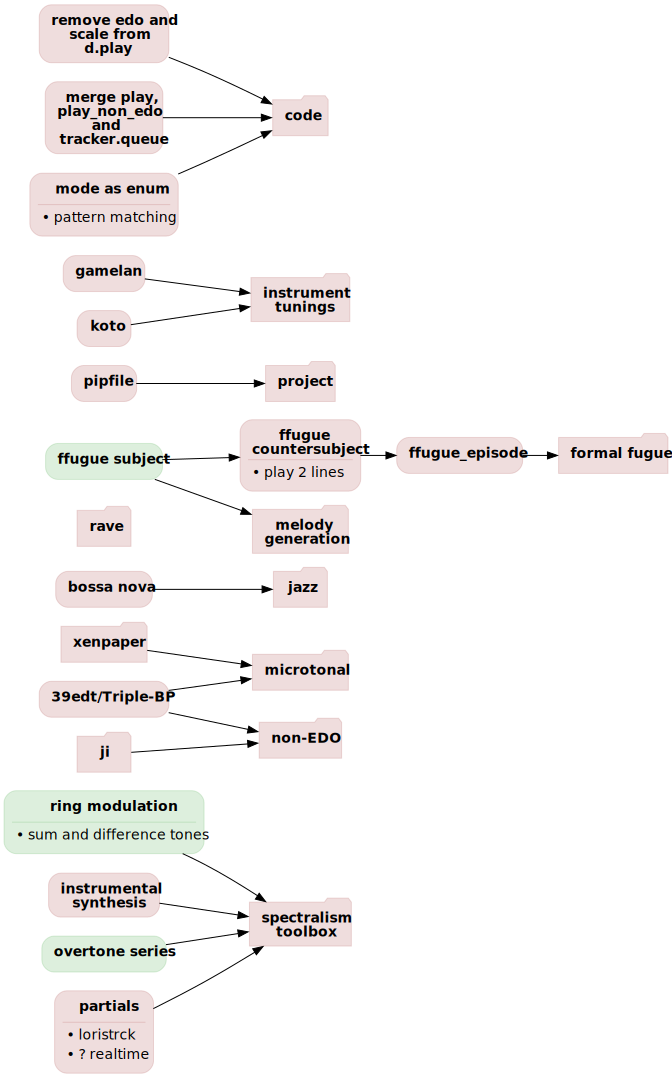

In [3]:
TaskTracker.clear()
T('spectralism toolbox', entry='spectralism', epic=True)
T('ring modulation', ['sum and difference tones'], 'ringmod', done=True) >> T('spectralism')
T('instrumental synthesis') >> T('spectralism')
T('overtone series', done=True) >> T('spectralism')
T('partials', ['loristrck', '? realtime'])>> T('spectralism')

T('microtonal', epic=True)
T('xenpaper', epic=True) >> T('microtonal')
T('39edt/Triple-BP', entry='39edt') >> T('microtonal')

T('jazz', epic=True)
T('bossa nova') >> T('jazz')

T('non-EDO', epic=True)
T('ji', epic=True)
T('ji') >> T('non-edo')
T('39edt') >> T('non-edo')

T('rave', epic=True)

T('formal fugue', entry='ffugue', epic=True)
T('ffugue subject', entry='ffugue_subj', done=True)
T('ffugue countersubject', ['play 2 lines'], entry='ffugue_csubj')
T('ffugue') << T('ffugue_episode') << T('ffugue_csubj') << T('ffugue_subj')

T('melody generation', entry='melody', epic=True)
T('ffugue_subj') >> T('melody')

T('project', epic=True)
T('pipfile') >> T('project')

T('instrument tunings', epic=True)
T('gamelan') >> T('instrument_tunings')
T('koto') >> T('instrument_tunings')

T('code', epic=True)
T('remove edo and scale from d.play') >> T('code')
T('merge play, play_non_edo and tracker.queue') >> T('code')
T('mode as enum', ['pattern matching']) >> T('code')

TaskTracker.draw()


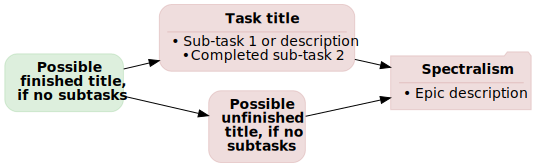

In [37]:
from typing import Optional, List
from dataclasses import dataclass, field
from enum import Enum, auto

from markdown_it import MarkdownIt

class ParseState(Enum):
    BEGIN = auto()
    H1 = auto()
    H2 = auto()
    P = auto()
    TEXT = auto()

@dataclass
class GradualTask():
    title: Optional[str] = None
    bullets: List[str] = field(default_factory=list)
    tags: List[str] = field(default_factory=list)
    entry: Optional[str] = None
    epic: bool = False
    done: bool = False

def parse_graph(graph):
    graph_lines = [line.strip() for line in graph.split('\n')]
    assert(graph_lines[0] == 'graph LR;')
    for line in graph_lines[1:]:
        if not line:
            continue
        entries = [entry.strip(';') for entry in line.split('-->')]
        assert len(entries) > 1
        for entry in entries:
            assert entry in TaskTracker.tasks
        for idx in range(1, len(entries)):
            T(entries[idx - 1]) >> T(entries[idx])

def strip_done(text):
    done = None
    if text.startswith('[ ] '):
        done = False
        text = text.removeprefix('[ ] ')
    elif text.startswith('[x] '):
        done = True
        text = text.removeprefix('[x] ')
    return done, text

md = (
    MarkdownIt('commonmark', {'breaks': True,'html': True})
)

md_text = open('task_example.md', 'r').read()

TaskTracker.clear()

tokens = md.parse(md_text)
state = ParseState.BEGIN
task = GradualTask()

for token in tokens:
    match token.type:
        case 'heading_open':
            if task.title is not None:
                T(task.title, bullets=task.bullets, entry=task.entry, epic=task.epic, done=task.done)
                task = GradualTask()
            match token.tag:
                case 'h1':
                    state = ParseState.H1
                    task.epic = True
                case 'h2':
                    state = ParseState.H2
                case _:
                    print(f'UNKNOWN tag {token.tag}')
                    assert False
        case 'inline':
            match state:
                case ParseState.H1 | ParseState.H2:
                    done, content = strip_done(token.content)
                    if done is not None:
                        task.done = done
                    words = content.split(' ')
                    title_words = []
                    for w in words:
                        match w[0]:
                            case '@':
                                task.entry = w[1:]
                            case '#':
                                task.tags.append(w[1:])
                            case _:
                                title_words.append(w)
                    task.title = ' '.join(title_words)
                case ParseState.P:
                    if not task.bullets:
                        task.done = True
                    done, content = strip_done(token.content)
                    if not done:
                        task.done = False
                    else:
                        content = f'<s>{content}</s>'
                    task.bullets.append(content)
                case _:
                    print(f'Unknown state {state}')
                    assert False
            state = ParseState.TEXT
        case 'paragraph_open':
            state = ParseState.P
        case 'fence':
            assert task.title is not None
            T(task.title, bullets=task.bullets, entry=task.entry, epic=task.epic, done=task.done)
            task = GradualTask()
            parse_graph(token.content)
        case _:
            if token.type not in ['heading_close', 'paragraph_close',
                                  'bullet_list_open', 'bullet_list_close',
                                  'list_item_open', 'list_item_close']:
                print(f'Unknown token type {token.type}')
                assert False
assert task.title is None

TaskTracker.draw()


In [ ]:
# possible markdown example
'''
# Spectralism
Epic description

## Task title @entry #tag1 #tag2
- [ ] Sub-task 1 or description
- [x] Completed sub-task 2

## [ ] Maybe also like this if we don't have subtasks
'''

# TODO: encode dependency graph in markdown using mermaid syntax
'''
```mermaid
  graph LR;
      A-->B;
      A-->C;
      B-->D;
      C-->D;
```
'''

# pros:
# - we can easily finish the tasks
# - on finishing each task we can add a release tag or smth
# - when writing entries in the graph we don't need class constructor like T(...)
# - business logic is separated from code
# - and different epics could be separated from each other in different files
# - we don't need to specify dependency on epic, because tasks are subchapters
# cons:
# - need to write a parser
# - graph is a bit separated from task descriptions, but maybe it's okay actually

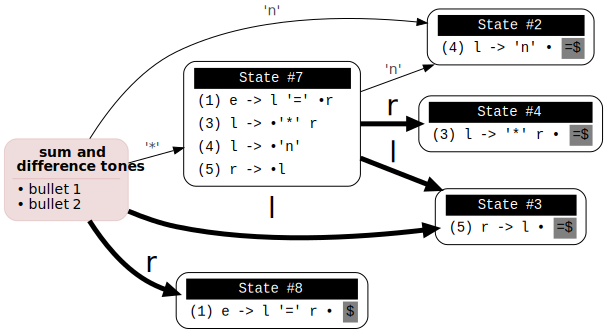

In [10]:

dot_string1 = """
digraph g {
  fontname="Futura,P052,Helvetica,Arial,sans-serif"
  node [style=filled fontname="Futura,P052,Helvetica,Arial,sans-serif"]
  edge [fontname="Futura,P052,Helvetica,Arial,sans-serif"]
  graph [fontsize=30 labelloc="t" label="" splines=true overlap=false rankdir = "LR"]
  ratio=auto
  state7 [
        color="#88000022"
        shape="Mrecord"
        label=<<table border="0" cellborder="0" cellspacing="0" cellpadding="4">
            <tr>
                <td align="center"><b>sum and<br/>difference tones</b></td>
            </tr>
            <hr/>
            <tr>
                <td align="left">• bullet 1<br/>• bullet 2</td>
            </tr>
        </table>>
  ]
  state2 [ style = "filled" penwidth = 1 fillcolor = "white" fontname = "Courier New" shape = "Mrecord" label =<<table border="0" cellborder="0" cellpadding="3" bgcolor="white"><tr><td bgcolor="black" align="center" colspan="2"><font color="white">State #2</font></td></tr><tr><td align="left" port="r4">&#40;4&#41; l -&gt; 'n' &bull;</td><td bgcolor="grey" align="right">=$</td></tr></table>> ]
  state3 [ style = "filled" penwidth = 1 fillcolor = "white" fontname = "Courier New" shape = "Mrecord" label =<<table border="0" cellborder="0" cellpadding="3" bgcolor="white"><tr><td bgcolor="black" align="center" colspan="2"><font color="white">State #3</font></td></tr><tr><td align="left" port="r5">&#40;5&#41; r -&gt; l &bull;</td><td bgcolor="grey" align="right">=$</td></tr></table>> ]
  state4 [ style = "filled" penwidth = 1 fillcolor = "white" fontname = "Courier New" shape = "Mrecord" label =<<table border="0" cellborder="0" cellpadding="3" bgcolor="white"><tr><td bgcolor="black" align="center" colspan="2"><font color="white">State #4</font></td></tr><tr><td align="left" port="r3">&#40;3&#41; l -&gt; '*' r &bull;</td><td bgcolor="grey" align="right">=$</td></tr></table>> ]
  state1 [ style = "filled" penwidth = 1 fillcolor = "white" fontname = "Courier New" shape = "Mrecord" label =<<table border="0" cellborder="0" cellpadding="3" bgcolor="white"><tr><td bgcolor="black" align="center" colspan="2"><font color="white">State #7</font></td></tr><tr><td align="left" port="r1">&#40;1&#41; e -&gt; l '=' &bull;r </td></tr><tr><td align="left" port="r3">&#40;3&#41; l -&gt; &bull;'*' r </td></tr><tr><td align="left" port="r4">&#40;4&#41; l -&gt; &bull;'n' </td></tr><tr><td align="left" port="r5">&#40;5&#41; r -&gt; &bull;l </td></tr></table>> ]
  state8 [ style = "filled" penwidth = 1 fillcolor = "white" fontname = "Courier New" shape = "Mrecord" label =<<table border="0" cellborder="0" cellpadding="3" bgcolor="white"><tr><td bgcolor="black" align="center" colspan="2"><font color="white">State #8</font></td></tr><tr><td align="left" port="r1">&#40;1&#41; e -&gt; l '=' r &bull;</td><td bgcolor="grey" align="right">$</td></tr></table>> ]
  state1 -> state4 [ penwidth = 5 fontsize = 28 fontcolor = "black" label = "r" ]
  state1 -> state2 [ penwidth = 1 fontsize = 14 fontcolor = "grey28" label = "'n'" ]
  state1 -> state3 [ penwidth = 5 fontsize = 28 fontcolor = "black" label = "l" ]
  state7 -> state8 [ penwidth = 5 fontsize = 28 fontcolor = "black" label = "r" ]
  state7 -> state1 [ penwidth = 1 fontsize = 14 fontcolor = "grey28" label = "'*'" ]
  state7 -> state2 [ penwidth = 1 fontsize = 14 fontcolor = "grey28" label = "'n'" ]
  state7 -> state3 [ penwidth = 5 fontsize = 28 fontcolor = "black" label = "l" ]
}
"""

graphs = pydot.graph_from_dot_data(dot_string1)
graph = graphs[0]
SVG(graph.create_svg())


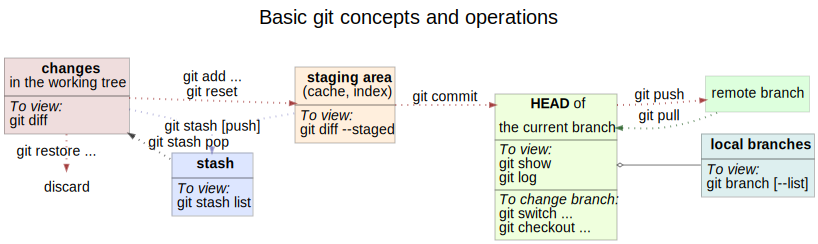

In [29]:
import pydot
from IPython.display import SVG


dot_string2 = """
digraph git_basics {
	graph [
		label = "Basic git concepts and operations\n\n"
		labelloc = t
		fontname = "Helvetica,Arial,sans-serif"
		fontsize = 20
		layout = dot
		rankdir = LR
		newrank = true
	]
	node [
		style=filled
		shape=rect
		pencolor="#00000044" // frames color
		fontname="Helvetica,Arial,sans-serif"
		shape=plaintext
	]
	edge [
		arrowsize=0.5
		fontname="Helvetica,Arial,sans-serif"
		labeldistance=3
		labelfontcolor="#00000080"
		penwidth=2
		style=dotted // dotted style symbolizes data transfer
	]
	changes [
		color="#88000022"
		label=<<table border="0" cellborder="1" cellspacing="0" cellpadding="4">
			<tr> <td> <b>changes</b><br/>in the working tree </td> </tr>
			<tr> <td align="left"><i>To view: </i><br align="left"/>
			git diff
			<br align="left"/></td> </tr>
		</table>>
		shape=plain
	]
	staging [
		fillcolor="#ff880022"
		label=<<table border="0" cellborder="1" cellspacing="0" cellpadding="4">
			<tr> <td> <b>staging area</b><br/>(cache, index)</td> </tr>
			<tr> <td align="left"><i>To view: </i><br align="left"/>
			git diff --staged
			<br align="left"/></td> </tr>
		</table>>
		shape=plain
	]
	staging -> HEAD:push [label="git commit" weight=1000 color="#88000088"]
	stash [
		fillcolor="#0044ff22"
		label=<<table border="0" cellborder="1" cellspacing="0" cellpadding="4">
			<tr> <td> <b>stash</b></td> </tr>
			<tr> <td align="left"><i>To view:</i><br align="left"/>
			git stash list
			<br align="left"/></td> </tr>
		</table>>
		shape=plain
	]
	stash_push [
		label="git stash [push]"
		style=""
		shape=plain
		color="#00008844"
	]
	{
		edge [arrowhead=none color="#00008844"]
		changes ->  stash_push
		stash_push -> staging
	}
	changes -> stash [
		dir=back
		xlabel="git stash pop"
		color="#00000088" weight=0]
	stash_push -> stash [xdir=back color="#00008844" minlen=0]
	HEAD [
		fillcolor="#88ff0022"
		label=<<table border="0" cellborder="1" cellspacing="0" cellpadding="3">
			<tr> <td port="push" sides="ltr"> <b>HEAD </b>of</td> </tr>
			<tr> <td port="pull" sides="lbr"> the current branch</td> </tr>
			<tr> <td port="switch" align="left">
				<i>To view:</i>
				<br align="left"/>
				git show<br align="left"/>
				git log
				<br align="left"/>
			</td> </tr>
			<tr> <td align="left">
				<i>To change branch:</i><br align="left"/>
				git switch ...
				<br align="left"/>
				git checkout ...
				<br align="left"/>
			</td> </tr>
		</table>>
		shape=plain
	]
	remote [
		label="remote branch"
		shape=box
		color="#00000022"
		fillcolor="#00ff0022"
	]

	HEAD:push -> remote [label="git push" color="#88000088"]
	HEAD:pull -> remote [dir=back label="git pull" color="#00440088"]
	branches [
		fillcolor="#00888822"
		label=<<table border="0" cellborder="1" cellspacing="0" cellpadding="4">
			<tr> <td> <b>local branches</b> </td> </tr>
			<tr> <td align="left"><i>To view:</i><br align="left"/>
			git branch [--list]
			<br align="left"/></td> </tr>
			</table>>
		shape=plain
	]
	changes -> staging [label="git add ...    \ngit reset      " color="#88000088"]
	discard [shape=plaintext style=""]
	changes -> discard [label="git restore ..." color="#88000088"]
	{rank=same changes discard}
	// UML style aggregation
	HEAD:switch -> branches [
		dir=back
		style=""
		penwidth=1
		arrowtail=odiamond
		arrowhead=none
		color="#00000088"
	]
}
"""

graphs = pydot.graph_from_dot_data(dot_string2)
graph = graphs[0]
SVG(graph.create_svg())

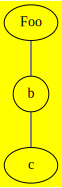

In [4]:
import pydot
from IPython.display import SVG

graph = pydot.Dot("my_graph", graph_type="graph", bgcolor="yellow")

# Add nodes
my_node = pydot.Node("a", label="Foo")
graph.add_node(my_node)
# Or, without using an intermediate variable:
graph.add_node(pydot.Node("b", shape="circle"))

# Add edges
my_edge = pydot.Edge("a", "b", color="blue")
graph.add_edge(my_edge)
# Or, without using an intermediate variable:
graph.add_edge(pydot.Edge("b", "c", color="blue"))
SVG(graph.create_svg())
# graph.write_png("output.png")

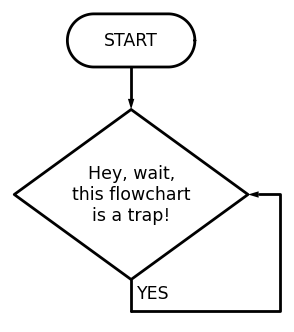

In [1]:
# import schemdraw
# from schemdraw import flow
# import matplotlib.pyplot as plt
# # plt.xkcd()

# with schemdraw.Drawing() as d:
#     d += flow.Start().label('START')
#     d += flow.Arrow().down(d.unit/3)
#     d += (h := flow.Decision(w=5.5, h=4, S='YES').label('Hey, wait,\nthis flowchart\nis a trap!'))
#     d += flow.Line().down(d.unit/4)
#     d += flow.Wire('c', k=3.5, arrow='->').to(h.E)

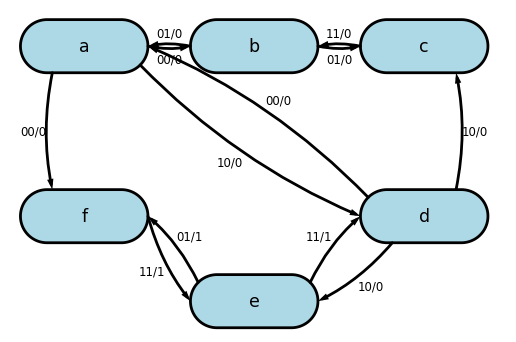

In [2]:
# import schemdraw.elements as elm

# with schemdraw.Drawing() as dwg:
#     dwg += (a := flow.Start().label('a').fill('lightblue'))
#     dwg += (b := flow.Start().at((4, 0)).label('b').fill('lightblue'))
#     dwg += (c := flow.Start().at((8, 0)).label('c').fill('lightblue'))
#     dwg += (f := flow.Start().at((0, -4)).label('f').fill('lightblue'))
#     dwg += (e := flow.Start().at((4, -6)).label('e').fill('lightblue'))
#     dwg += (d := flow.Start().at((8, -4)).label('d').fill('lightblue'))
# #     dwg += elm.ArcLoop(arrow='->').at(a.NW).to(a.NNE).label('00/0', fontsize=10)
# #     dwg += elm.ArcLoop(arrow='->').at(b.NNW).to(b.NE).label('01/0', fontsize=10)
# #     dwg += elm.ArcLoop(arrow='->').at(c.NNW).to(c.NE).label('11/0', fontsize=10)
# #     dwg += elm.ArcLoop(arrow='->').at(d.E).to(d.SE).label('10/0', fontsize=10)
# #     dwg += elm.ArcLoop(arrow='->').at(e.SSE).to(e.SW).label('11/1', fontsize=10)
# #     dwg += elm.ArcLoop(arrow='->').at(f.S).to(f.SW).label('01/1', fontsize=10)
#     dwg += elm.Arc2(k=.1, arrow='<-').at(a.ENE).to(b.WNW).label('01/0', fontsize=10)
#     dwg += elm.Arc2(k=.1, arrow='<-').at(b.W).to(a.E).label('00/0', fontsize=10)
#     dwg += elm.Arc2(k=.1, arrow='<-').at(b.ENE).to(c.WNW).label('11/0', fontsize=10)
#     dwg += elm.Arc2(k=.1, arrow='<-').at(c.W).to(b.E).label('01/0', fontsize=10)
#     dwg += elm.Arc2(k=.1, arrow='<-').at(a.ESE).to(d.NW).label('00/0', fontsize=10)
#     dwg += elm.Arc2(k=.1, arrow='<-').at(d.WNW).to(a.SE).label('10/0', fontsize=10)
#     dwg += elm.Arc2(k=.1, arrow='<-').at(f.ENE).to(e.NW).label('01/1', fontsize=10)
#     dwg += elm.Arc2(k=.1, arrow='<-').at(e.WNW).to(f.ESE).label('11/1', fontsize=10)
#     dwg += elm.Arc2(k=.1, arrow='->').at(e.NE).to(d.WSW).label('11/1', fontsize=10)
#     dwg += elm.Arc2(k=.1, arrow='->').at(d.SSW).to(e.ENE).label('10/0', fontsize=10)
#     dwg += elm.Arc2(k=.1, arrow='<-').at(f.NNW).to(a.SSW).label('00/0', fontsize=10)
#     dwg += elm.Arc2(k=.1, arrow='<-').at(c.SSE).to(d.NNE).label('10/0', fontsize=10)


In [ ]:
# from diagrams import Diagram
# from diagrams.c4 import Person, Container, Database, System, SystemBoundary, Relationship

# graph_attr = {
#     "splines": "spline",
# }

# with Diagram("Container diagram for Internet Banking System", direction="TB", graph_attr=graph_attr):
#     customer = Person(
#         name="Personal Banking Customer", description="A customer of the bank, with personal bank accounts."
#     )

#     with SystemBoundary("Internet Banking System"):
#         webapp = Container(
#             name="Web Application",
#             technology="Java and Spring MVC",
#             description="Delivers the static content and the Internet banking single page application.",
#         )

#         spa = Container(
#             name="Single-Page Application",
#             technology="Javascript and Angular",
#             description="Provides all of the Internet banking functionality to customers via their web browser.",
#         )

#         mobileapp = Container(
#             name="Mobile App",
#             technology="Xamarin",
#             description="Provides a limited subset of the Internet banking functionality to customers via their mobile device.",
#         )

#         api = Container(
#             name="API Application",
#             technology="Java and Spring MVC",
#             description="Provides Internet banking functionality via a JSON/HTTPS API.",
#         )

#         database = Database(
#             name="Database",
#             technology="Oracle Database Schema",
#             description="Stores user registration information, hashed authentication credentials, access logs, etc.",
#         )

#     email = System(name="E-mail System", description="The internal Microsoft Exchange e-mail system.", external=True)

#     mainframe = System(
#         name="Mainframe Banking System",
#         description="Stores all of the core banking information about customers, accounts, transactions, etc.",
#         external=True,
#     )

#     customer >> Relationship("Visits bigbank.com/ib using [HTTPS]") >> webapp
#     customer >> Relationship("Views account balances, and makes payments using") >> [spa, mobileapp]
#     webapp >> Relationship("Delivers to the customer's web browser") >> spa
#     spa >> Relationship("Make API calls to [JSON/HTTPS]") >> api
#     mobileapp >> Relationship("Make API calls to [JSON/HTTPS]") >> api

#     api >> Relationship("reads from and writes to") >> database
#     api >> Relationship("Sends email using [SMTP]") >> email
#     api >> Relationship("Makes API calls to [XML/HTTPS]") >> mainframe
#     customer << Relationship("Sends e-mails to") << email
